### Main document for storing examples and whatnots

In [1]:
%run ./Library.ipynb #importing my little library of things the Stupid Way :-)

All quiet on the errors front


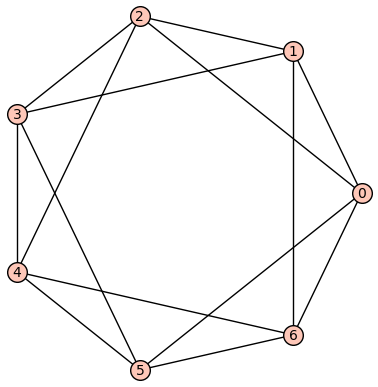

In [2]:
#Example of constructing Circulant Graph on 7 vertices with flat orthogonal representation
G = graphs.CirculantGraph(7,[1,2])

vecs = [None for i in range(7)]
vecs[0] = Matrix([-1, 1, 1, 1])
vecs[1] = Matrix([ 1, -1, 1, 1])
vecs[2] = Matrix([ 1, 1, -1, 1])
vecs[3] = Matrix([ 1, 1, 1, -1])
vecs[4] = Matrix([ -1, 1, 1, 1])
vecs[5] = Matrix([ 1, -1, 1, 1])
vecs[6] = Matrix([ 1, 1, -1, 1])

lib_quat_const(vecs)
lib_check_qch(lib_quat_const(vecs),G,G.vertices())
G.show()



All quiet on the errors front


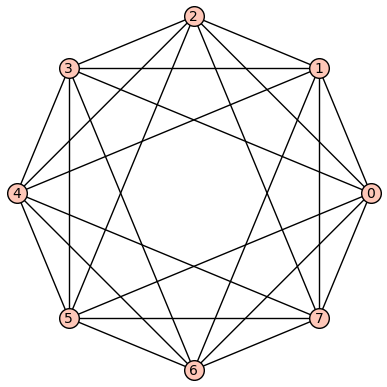

4

In [3]:
#Example of constructing Circulant Graph on 8 vertices with flat orthogonal representation
G = graphs.CirculantGraph(8,[1,2,3])

vecs = [None for i in range(8)]
vecs[0] = Matrix([-1, 1, 1, 1])
vecs[1] = Matrix([ 1, -1, 1, 1])
vecs[2] = Matrix([ 1, 1, -1, 1])
vecs[3] = Matrix([ 1, 1, 1, -1])
vecs[4] = Matrix([ -1, 1, 1, 1])
vecs[5] = Matrix([ 1, -1, 1, 1])
vecs[6] = Matrix([ 1, 1, -1, 1])
vecs[7] = Matrix([ 1, 1,  1, -1])
lib_quat_const(vecs)
lib_check_qch(lib_quat_const(vecs),G,G.vertices())
G.show()

G.chromatic_number()


All quiet on the errors front


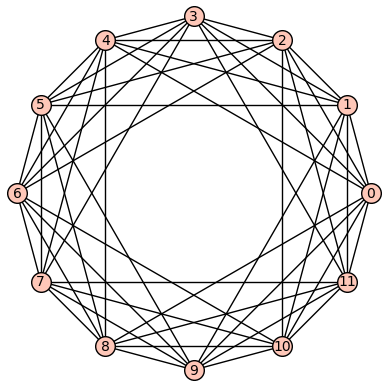

6

In [4]:
#Example of constructing Circulant Graph on 12 vertices with flat orthogonal representation
G = graphs.CirculantGraph(12,[1,2, 3, 4])

vecs = [None for i in range(12)]
vecs[0] = Matrix([-1, -1, -1, -1,  1,  1,  1,  1])
vecs[1] = Matrix([-1, -1,  1,  1, -1, -1,  1,  1])
vecs[2] = Matrix([ 1, -1,  1, -1,  1, -1, -1,  1])
vecs[3] = Matrix([ 1, -1,  1, -1, -1,  1,  1, -1])
vecs[4] = Matrix([-1,  1,  1, -1, -1,  1, -1,  1])
vecs[5] = Matrix([ 1,  1, -1, -1, -1, -1,  1,  1])
vecs[6] = Matrix([ 1,  1,  1,  1,  1,  1,  1,  1])
vecs[7] = Matrix([-1, -1, -1, -1,  1,  1,  1,  1])
vecs[8] = Matrix([-1, -1,  1,  1, -1, -1,  1,  1])
vecs[9] = Matrix([ 1, -1,  1, -1,  1, -1, -1,  1])
vecs[10] = Matrix([ 1, -1,  1, -1, -1,  1,  1, -1])
vecs[11] = Matrix([-1,  1,  1, -1, -1,  1, -1,  1])


lib_oct_const(vecs)
lib_check_qch(lib_oct_const(vecs),G,G.vertices())
G.show()

G.chromatic_number()


In [7]:
## This is me trying to brute force something with a (random) 4d orthogonal representation that, when reconstructed, gives
# a graph with chromatic number greater than or equal to five. Yeah it's stupid. I know.

def pull_shit_from_nothing(n,d):
    pm = [-1,0,1]
    vecs = [None for i in range(n)]
    for i in range(n):
        vecs[i] = Matrix([pm[randrange(0,3)] for j in range(d)])
    G_r = lib_reconstructing(vecs, [i for i in range(n)])
    return G_r, vecs

def more_shit_pulling(it,n,d):
    pm = [-1,1]
    Gs = []
    vecs = []
    for i in range(it):
        [G_r,vecs_r] = pull_shit_from_nothing(n,d)
        ind = 1;
        for j in range(n):
            if abs(vecs_r[j].norm()) <= 1e-5:
                ind = 0;
        if (G_r.is_connected() == 1) and (G_r.chromatic_number() >= 4) and (ind == 1):
            #print('ye')
            Gs.append(G_r)
            vecs.append(vecs_r)

    return Gs, vecs
[Gs, vecs] =more_shit_pulling(40,13,4)
Gs

[Graph on 13 vertices,
 Graph on 13 vertices,
 Graph on 13 vertices,
 Graph on 13 vertices]